In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Very hacky, bad thing to do.
SRC_PATH = os.path.realpath('../src')
sys.path.append(SRC_PATH)

In [19]:
# Local imports.
from analysis import single_cycles
from defaults import PITCH_RATE, SAMPLE_RATE
from synthesis import EnvelopeMorpher, StimulusGenerator
from util import midi_to_hz, time_plot, stft_plot

In [20]:
# Synthesis parameters.
num_partials = 70
midi_pitch = 48
fm_depth = 0.1314
f0 = midi_to_hz(midi_pitch)

In [21]:
# Load env as linear amplitude. (CheapTrick calculates the power spectrum.)
env = single_cycles[0]['env']
env = np.sqrt(env)

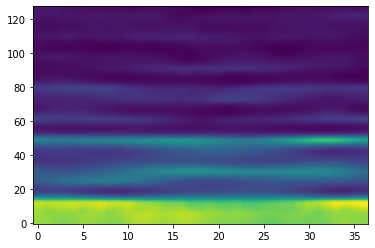

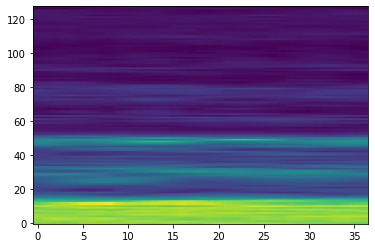

In [22]:
# Modify the spectral envelopes.

morpher = EnvelopeMorpher(env)
morpher.show(zoom=8)

morpher.shuffle_phase(num_shifts=4)
morpher.show(zoom=8)

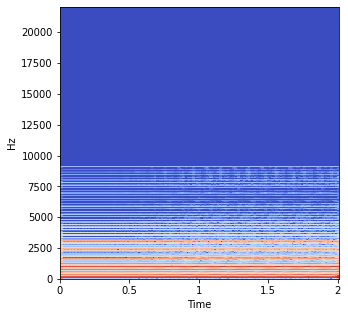

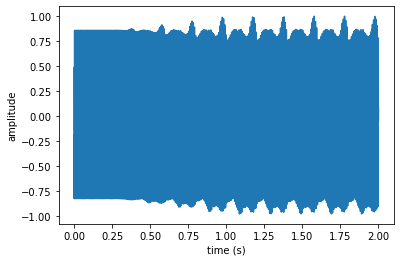

In [23]:
generator = StimulusGenerator(sr=SAMPLE_RATE, pr=PITCH_RATE)

# FROZEN reconstruction condition (unmorphed, no FM).
x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=env,
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

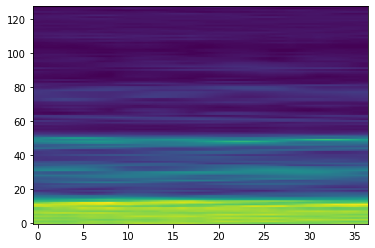

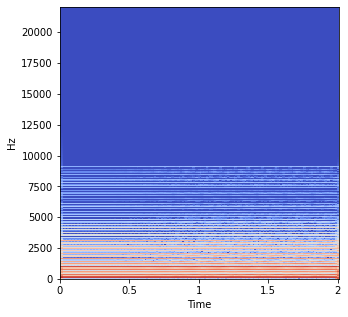

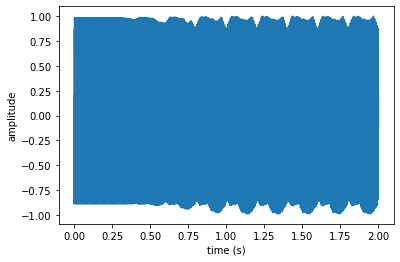

In [24]:
# Amplitude modulation phase-shuffled condition.

morpher.shuffle_phase(num_shifts=4)
morpher.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=morpher(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

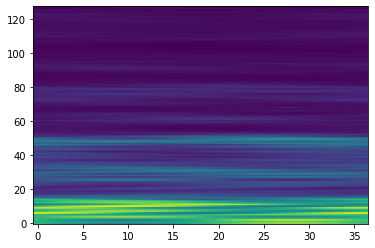

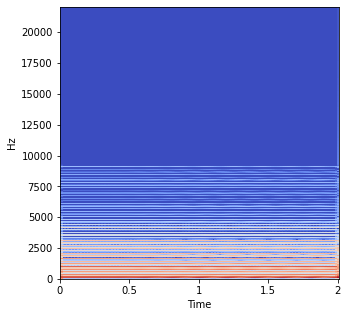

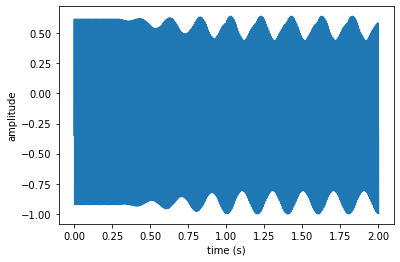

In [29]:
# Random amplitude gain and phase-shuffled condition.

morpher.rap(max_gain=10)
morpher.shuffle_phase(num_shifts=4)
morpher.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=morpher(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

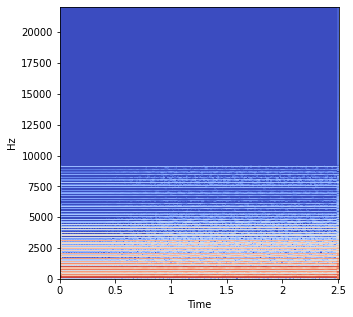

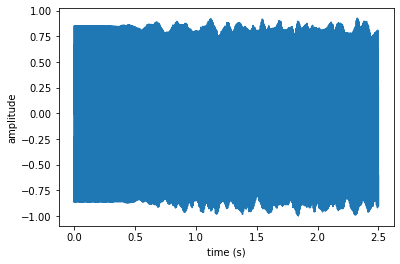

In [30]:
# Random amplitude modulation rate condition (RAF).

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=env,
    num_partials=70,
    length=2.5,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
    synth_mode='raf',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

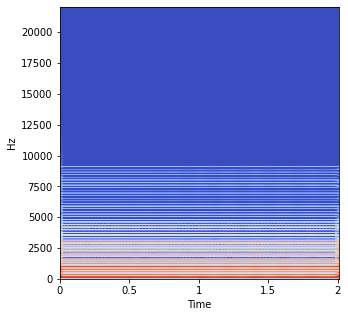

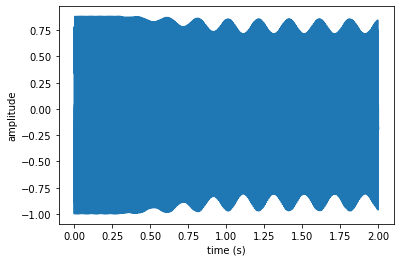

In [31]:
# PAM mode, pure amplitude modulation condition (a.k.a. tremolo).

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=morpher(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
    synth_mode='pam',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))